In [82]:
import torch 
from torch import nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import transforms, datasets
from torch import optim
import torch.nn.functional as F

In [83]:
print(f'The version of torch is : {torch.__version__}\nThe version of torchvision is : {torchvision.__version__}')

The version of torch is : 2.0.1
The version of torchvision is : 0.15.2


In [84]:
'''
// 폴더 구조
dataset/
├── seg_pred/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── seg_train/
│   ├── class1/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   ├── class2/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── ...
└── seg_test/
    ├── class1/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    ├── class2/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── ...'''

'\n// 폴더 구조\ndataset/\n├── seg_pred/\n│   ├── image1.jpg\n│   ├── image2.jpg\n│   └── ...\n├── seg_train/\n│   ├── class1/\n│   │   ├── image1.jpg\n│   │   ├── image2.jpg\n│   │   └── ...\n│   ├── class2/\n│   │   ├── image1.jpg\n│   │   ├── image2.jpg\n│   │   └── ...\n│   └── ...\n└── seg_test/\n    ├── class1/\n    │   ├── image1.jpg\n    │   ├── image2.jpg\n    │   └── ...\n    ├── class2/\n    │   ├── image1.jpg\n    │   ├── image2.jpg\n    │   └── ...\n    └── ...'

데이터 전처리

In [85]:
train_dir = 'dataset/seg_train/seg_train'
test_dir = 'dataset/seg_test/seg_test'
batch_size = 32
transform = transforms.Compose(
    [transforms.Resize(64),
     transforms.CenterCrop(64),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)])

# ImageFolder 메소드를 사용하기 위해서는 훈련 폴더 안에 각각의 클래스가 하위 폴더 안에 저장돼있어야 한다.
train_dataset = datasets.ImageFolder(train_dir, 
                               transform=transform)

# 데이터셋을 미니 배치로 나누고 shuffle하는 역할
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

# 테스트 셋에 대해서도 같은 코드 적용
test_dataset = datasets.ImageFolder(test_dir, 
                               transform=transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              drop_last=True)


In [86]:
# dataloader를 반복 가능한 객체로 생성후 첫번째 배치(길이=32)의 사진과 라벨 저장
images, labels = next(iter(train_dataloader))

변환한 이미지 출력해보기

torch.Size([64, 64])


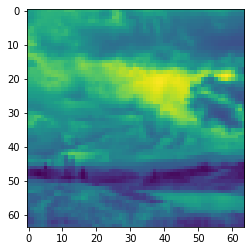

In [87]:
import matplotlib.pyplot as plt
tf = transforms.ToPILImage()
img = images[0][0]
plt.imshow(img)
print(img.shape)

In [91]:
class CNN(nn.Module):
    def __init__(self):
        # 이 클래스는 nn.Module을 상속한다.
        super(CNN, self).__init__()
        # convolution layer: 처음 채널은 RGB이므로 3이며 out_channels을 점점 증가시켜가며 저수준에서 고수준으로의 학습을 한다.
        # padding을 통해 이미지의 사이즈를 보존할 수 있다.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)    # 64, 64, 64
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)  # 128, 64, 64
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1) # 256, 64, 64
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1) # 512, 64, 64

        # pooling: 2*2 커널 사이즈를 통해 사진의 복잡도 줄임
        self.pool = nn.MaxPool2d(kernel_size=2) # 512, 32, 32
        
        # 4번의 pooling을 거치기 때문에 64/2**4 = 4*4의 이미지 형성(forward 함수 참고)
        self.fc1 = nn.Linear(in_features=512 * 4 * 4, out_features=128)
        # 클래스 개수인 6을 out_features로 결정
        self.fc2 = nn.Linear(in_features=128, out_features=6)
    
        self.dropout = nn.Dropout(0.25)

    # 순전파 과정 함수
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # 평탄화 작업을 통해 벡터를 일렬로 펼침
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

training

In [92]:
from tqdm import tqdm

device = torch.device('mps')
def fit(epochs, model, criterion, optimizer, device=device, dataloader=train_dataloader):
    
    for e in tqdm(range(epochs)):
        running_loss = 0
        for images, labels in dataloader:

            # 그래디언트 초기화
            optimizer.zero_grad()
            output = model(images)
            # 손실 계산
            loss = criterion(output, labels)
            # 역전파 과정
            loss.backward()
            # 가중치 업데이트
            optimizer.step()
            
            running_loss += loss.data
        else:
            print(f" Epoch {e}, Training loss: {running_loss/len(dataloader)}")  

In [95]:
epochs = 10
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

fit(epochs, model, criterion, optimizer)

 10%|█         | 1/10 [03:53<35:01, 233.45s/it]

 Epoch 0, Training loss: 1.2914899587631226


 20%|██        | 2/10 [07:29<29:46, 223.36s/it]

 Epoch 1, Training loss: 0.9506558179855347


 30%|███       | 3/10 [11:25<26:43, 229.10s/it]

 Epoch 2, Training loss: 0.797662615776062


 40%|████      | 4/10 [15:04<22:30, 225.06s/it]

 Epoch 3, Training loss: 0.6789867877960205


 50%|█████     | 5/10 [18:39<18:27, 221.55s/it]

 Epoch 4, Training loss: 0.5957074165344238


 60%|██████    | 6/10 [22:11<14:33, 218.30s/it]

 Epoch 5, Training loss: 0.5232073068618774


 70%|███████   | 7/10 [25:46<10:51, 217.21s/it]

 Epoch 6, Training loss: 0.4641572833061218


 80%|████████  | 8/10 [29:34<07:20, 220.40s/it]

 Epoch 7, Training loss: 0.40475785732269287


 90%|█████████ | 9/10 [33:45<03:50, 230.23s/it]

 Epoch 8, Training loss: 0.3477785587310791


100%|██████████| 10/10 [38:17<00:00, 229.79s/it]

 Epoch 9, Training loss: 0.2921448051929474
